<a id="Data_Analysis_R"></a>
# Data Analysis R

This notebook contains an R based analysis for the creation of a composite model for method selection. It partially draws on previous analysis in Python and R and therefore neglects some of the basic analyses of the explanatory variables.

[Data Analysis R](#Data_Analysis_R)

- [Configurations](#Configurations)
- [Data Acquisition](#Data_Acquisition)
- [Classification Model](#Classification_Model)
    - [Common Functions](#Common_Functions)
    - [Composite Model](#Composite_Model)
    - [Final Model Analysis](#Final_Model_Analysis)
    - [Paper Visualisations](#Paper_Visualisations)

<a id="Configurations"></a>
## Configurations

In [141]:
#Import packages 
library(ggpubr)
library(gridExtra)
library(plyr)
library(dplyr) 
library(tidyverse)
library(mlbench)
library(caret)
library(nnet)
library(pROC)
library(mgcv)
library(fastDummies)

library(repr)
library(MASS)
library(car)
library(nortest)
library(moments)
library(transport)



In [142]:
#Set language to get english errors and messages
Sys.setenv(LANG = "en")

<a id="Data_Acquisition"></a>
## Data Acquisition

In [143]:
#Read data for plots
csv_out_path <- "./Data/detection_aggregated_lfi_v1.csv"
lfi_trees_grouped <- read.csv(csv_out_path,sep=";",quote = "\"")

In [144]:
#Labels for filter methods
parameterset_lookup_labels<-data.frame(val=c( '1m','1.5m','2m','1m, sigma 1, size 3','1m, sigma 1, size 5','1m, sigma 1, size 7','1m, sigma 2, size 3','1m, sigma 2, size 5','1m, sigma 2, size 7','1m, sigma 3, size 3','1m, sigma 3, size 5','1m, sigma 3, size 7','1.5m, sigma 2, size 3','1.5m, sigma 2, size 5','1.5m, sigma 2, size 7','combined 1m/1.5m/1m, sig2, r3','combined 1m/2m/1m, sig2, r5','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3/1m, sig3, r3'), row.names=c( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))

In [145]:
nh_lookup_labels<-data.frame(val=c( '1) broadleaved dominated','2) mixed','3) coniferous dominated'), row.names=c( 1,2,3))
dg_lookup_labels<-data.frame(val=c( '1) <= 80%','2) > 80%'), row.names=c( 1,2))
hdom_lookup_labels<-data.frame(val=c( '1) <= 22 m','2) > 22m'), row.names=c( 1,2))

In [146]:
#Read aggregated data output created by the F:\fint-ch\python\git\fint_ch\AP07__Kalibrieren_der_EBD_Regeln\Python\fint_ch_diss_method_combination_processing.py
csv_out_path <- "./Data/method_combinations_lfi_reduced.csv"
method_combinations <-  read.csv(csv_out_path,sep=";",quote = "\"",stringsAsFactors=FALSE)

In [147]:
#Excluding specific cases
print(count(lfi_trees_grouped)$n)
#Cases with very high stems per ha in baseline ; 3
lfi_trees_grouped <- lfi_trees_grouped[ !(lfi_trees_grouped$flaeche_id %in% c(40321,154907,156044)),]
print(count(lfi_trees_grouped)$n)
#Cases without reference value ; 2
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$density_actual_all)),] 
print(count(lfi_trees_grouped)$n)

[1] 5915
[1] 5912
[1] 5910


In [148]:
#Excluding cases without reference data
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$nbr_trees_os) | is.na(lfi_trees_grouped$nbr_trees) | (lfi_trees_grouped$nbr_trees_os==0) | (lfi_trees_grouped$nbr_trees_os==-1)),] 
print(count(lfi_trees_grouped)$n)

##Cases with reference value 0 ; 329
#lfi_trees_grouped = lfi_trees_grouped[np.invert((lfi_trees_grouped["density_actual"]==0)&(lfi_trees_grouped["density_actual_all"]==0))].reset_index() 
#print(len(lfi_trees_grouped))

[1] 5254


In [149]:
#Replacing placeholders in stem counts per ha (they could mess up some charts and operations)
for (i in 1:19){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

In [150]:
for (i in 1:19){    
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    # lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")][is.na(lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")])] <- 99
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    # lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")][is.na(lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")])] <- 99
}


In [151]:
#Deriving attributes from existing data 
lfi_trees_grouped["acquisition_diff"] <- lfi_trees_grouped["VHM_Tile_Year"]-lfi_trees_grouped["year"]
lfi_trees_grouped["acquisition_diff_abs"] <- abs(lfi_trees_grouped["acquisition_diff"])

lfi_trees_grouped["veg_code_complete"] <- lfi_trees_grouped["veg_code"]*100+lfi_trees_grouped["veg_subcode"]
lfi_trees_grouped["constant"] <- 1

lfi_trees_grouped["dg_scaled"] <- lfi_trees_grouped["dg"]/100
lfi_trees_grouped["hdom_scaled"] <- lfi_trees_grouped["hdom"]/100
lfi_trees_grouped["nh_scaled"] <- lfi_trees_grouped["nh"]/100

In [152]:
#Excluded methods 3,8,9,11,12,13,14,15
determine_min_class_flex <- function (x, input_prefix="stems_per_ha_rs_", input_classes=c(1,2,7,4,5,6,10,16,17,18,19)){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))

    min_val = min(x[unlist(input_columns)])

    for (i in input_classes){
        if (x[paste(input_prefix,"ps",i,sep="")] == min_val) {
            return(i)
        }
    }
}

#Determine method with minimal squared difference
lfi_trees_grouped["parameterset_min_reduced"] <- apply(lfi_trees_grouped,1,function(x) determine_min_class_flex(x, input_prefix="stems_per_ha_rs_"))    
    
lfi_trees_grouped["parameterset_min_reduced7"] <- apply(lfi_trees_grouped,1,function (x)determine_min_class_flex(x, input_prefix="stems_per_ha_rs_", input_classes=c(1,2,7,8,10,16,19)))
lfi_trees_grouped["parameterset_min_reduced6"] <- apply(lfi_trees_grouped,1,function (x)determine_min_class_flex(x, input_prefix="stems_per_ha_rs_", input_classes=c(1,2,7,10,16,19)))
lfi_trees_grouped["parameterset_min_reduced16"] <- apply(lfi_trees_grouped,1,function (x)determine_min_class_flex(x, input_prefix="stems_per_ha_rs_", input_classes=c(1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 19)))
lfi_trees_grouped["parameterset_min_reduced11"] <- apply(lfi_trees_grouped,1,function(x)determine_min_class_flex(x, input_prefix="stems_per_ha_rs_"))


In [153]:
eps=0.0001
pid <- 0
determine_min_labels <- function (df, input_prefix="stems_per_ha_rs_", output_prefix="ps", input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19)){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))
    
    df$tmp_min <- apply(df[unlist(input_columns)],1,min)

    for (i in 1:length(input_classes)) {
        ps=input_classes[[i]]
        df[paste(output_prefix,ps,sep="")] <-  (abs((df[paste(input_prefix,"ps",ps,sep="")] - df$tmp_min))<eps)*1
    }             
    return(subset(df, select = -c(tmp_min) ))
}

lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps", input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
                            
lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps7", input_classes=c(1,2,7,8,10,16,19))
lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps6", input_classes=c(1,2,7,10,16,19))

In [154]:
lfi_trees_grouped$parameterset_min <- as.factor(lfi_trees_grouped$parameterset_min)  
lfi_trees_grouped$parameterset_min_reduced <- as.factor(lfi_trees_grouped$parameterset_min_reduced)  
lfi_trees_grouped$parameterset_min_reduced7 <- as.factor(lfi_trees_grouped$parameterset_min_reduced7)  
lfi_trees_grouped$parameterset_min_reduced11 <- as.factor(lfi_trees_grouped$parameterset_min_reduced11)
lfi_trees_grouped$parameterset_min_reduced16 <- as.factor(lfi_trees_grouped$parameterset_min_reduced16)  

In [155]:
#Not clear if this is necessary/wise
lfi_trees_grouped$fst <- as.factor(lfi_trees_grouped$fst)  
lfi_trees_grouped$fst_nh <- as.factor(lfi_trees_grouped$fst_nh)  
lfi_trees_grouped$fst_dg <- as.factor(lfi_trees_grouped$fst_dg)  
lfi_trees_grouped$fst_hdom <- as.factor(lfi_trees_grouped$fst_hdom)  
lfi_trees_grouped$veg_code <- as.factor(lfi_trees_grouped$veg_code)  
lfi_trees_grouped$veg_subcode <- as.factor(lfi_trees_grouped$veg_subcode)  
lfi_trees_grouped$veg_code_complete <- as.factor(lfi_trees_grouped$veg_code_complete)  
lfi_trees_grouped$waldrand <- as.factor(lfi_trees_grouped$bestandesgrenze)  
lfi_trees_grouped$bestandesgrenze <- as.factor(lfi_trees_grouped$bestandesgrenze)

In [156]:
# lfi_trees_grouped$nh10 <- as.factor((lfi_trees_grouped$nh) %/% 10)
# lfi_trees_grouped$dg10 <- as.factor((lfi_trees_grouped$dg) %/% 10)
# lfi_trees_grouped$hdom5 <- as.factor((lfi_trees_grouped$hdom) %/% 7)

lfi_trees_grouped$nh_class <- as.factor(data.frame(lapply(lfi_trees_grouped$nh,function(x) ifelse(0<=x && x<20,1,ifelse(20<=x && x<40,2,ifelse(40<=x && x<60,3,ifelse(60<=x && x<80,4, 5)))))))
lfi_trees_grouped$dg_class <- as.factor(data.frame(lapply(lfi_trees_grouped$dg,function(x) ifelse(0<=x && x<40,1,ifelse(40<=x && x<60,2,ifelse(60<=x && x<80,3,4))))))
lfi_trees_grouped$hdom_class <- as.factor(data.frame(lapply(lfi_trees_grouped$hdom,function(x) ifelse(0<=x && x<12,1,ifelse(12<=x && x<24,2,ifelse(24<=x && x<30,3,4))))))

In [157]:
#Add dummy 0/1 columns for selected factors
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_nh")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_dg")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_hdom")
        

In [158]:
#Adding log transformed error and errors normalized by the density within the plot
for (i in 1:19){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

In [159]:
print(paste(colnames(lfi_trees_grouped), collapse = "', '"))

[1] "index', 'perimeter_id', 'flaeche_id', 'source_id', 'source_label', 'slope', 'slope_class', 'slope_sin', 'aspect', 'aspect_class', 'aspect_cos', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 'veg_de', 'veg_subcode', 'fst', 'fst_dg', 'fst_hdom', 'fst_nh', 'dg', 'hdom', 'nh', 'hdom50', 'dg50', 'nh50', 'fst50', 'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 'dg_ks50', 'dg_us50', 'dg_ms50', 'dg_os50', 'dg_ueb50', 'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 'local_peaks', 'x_lv95', 'y_lv95', 'waldrand', 'bestandesgrenze', 'nbr_trees', 'nbr_trees_os', 'bas_ref', 'year', 'density_actual', 'density_actual_all', 'bas_per_ha_ref', 'KANTONSNUM', 'VHM_Year_Min', 'VHM_Year_Max', 'VHM_Tile_Year', 'plot_area', 'stems_per_ha_ps1', 'stems_per_ha_ps2', 'stems_per_ha_ps3', 'stems_per_ha_ps4', 'stems_per_ha_ps5', 'stems_per_ha_ps6', 'stems_per_ha_ps7', 'stems_per_ha_ps8', 'stems_per_ha_ps9', 'stems_per_ha_ps10', 'stems_

<a id="Classification_Model"></a>
## Classification Model

<a id="Common_Functions"></a>
### Common Functions

In [160]:
#Setting input data
target_col = 'stems_per_ha_err_ps1'
cols_complete = c(  'slope_sin', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 
  'fst', 'fst_nh', 'fst_dg', 'fst_hdom',
  'dg', 'hdom', 'nh', 
  # 'hdom50', 'dg50', 'nh50', 'fst50', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  # 'dg_ks50', 'dg_us50', 'dg_ms50', 'dg_os50', 'dg_ueb50', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  # 'x_lv95', 'y_lv95', 
  'waldrand', 'bestandesgrenze','local_peaks'
 ) 
cols_reduced = c(  
  'slope_sin', 'northness', 'eastness', 'z', 
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  'local_peaks'
 ) 


In [161]:
#Function for partitioning data into train/test
get_partitions <- function(target_col, data=lfi_trees_grouped, x_columns=cols_complete, train_size=0.8, random_state=42){
    set.seed(random_state)
    data_filtered <- data[!is.na(data[,target_col]),]
    in_train <- createDataPartition(data_filtered[,target_col], p = train_size)
    cols_combined = c(x_columns, target_col)
    return(list(
        in_train = in_train[[1]],
        train = data_filtered[in_train[[1]],cols_combined],
        test = data_filtered[-in_train[[1]],cols_combined]
    ))
}


In [162]:
#For lookup purposes when applying FST expert approach
fst_parameterset_mappings <- structure(c(2,2,7,16,
                                         2,16,7,16,
                                         16,16,16,16), 
                                names=c("111","112","121","122",
                                 "211","212","221","222",
                                 "311","312","321","322") ) 

<a id="Composite_Model"></a>
## Composite Model

An attempt to integrate the composite model with caret failed. This is mostly due to the fact that handling multiply y values as input doesn't seem to be possible. Furthermore, the mox between regression and classification lite it is used here, seem also to be outside of caret's scope. Therefore two seperate methods fitting and predicting the model were created. The fitting method fintch.composite.fit() uses caret under the hood to fit a regression model for the specified classes and returns an object containing the trained models and necessary parameters for prediction. The fintch.composite.predict() method uses that fitted model object along with new input data to make the actual predictions.  

In [163]:
# Method for fitting a composite mode for the specified Date and filter methods
# x: data containing the explanatory data
# y: Data containing the error values to be used as target for the models. Must contain a column per filter method.
# targets: Vector with the numbers of the filter methods to be used in the model
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# method: method used to fit the error models (lm, leap, lasso, ridge, rf)
# direction: direction for leap method (forwart, backward, both)
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# mtry: mtry value for rf method
fintch.composite.fit <- function(x, y, targets, target_prefix, cv, method="lm", direction="forward",  dynamic=TRUE, nvmax=5, mtry=10) { 
    #Fit model per method/column in y
    models <- list()

    for(i in 1:length(targets)) {                        
        #Get taret name/method 
        target_name <-  targets[i]

        #Get corresponding column
        target_col <- paste(target_prefix, target_name, sep="")
        y_target <- y[target_col]
        
        x_train <- cbind(x,y_target)
        x_train <- x_train[!is.na(x_train[target_col]),]

        
        #Perform sequential feature selection on base learner
        control <- trainControl(method="repeatedcv", number=cv, repeats=3, allowParallel=TRUE)
        if (dynamic) {
            model_string <- paste(target_col,"~.",sep="")                                                
        } else {
            model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_mean+tri_std+tpi_mean+tpi_std+local_peaks",sep="")                                                
        }
        if (method=="lm") {
            if (dynamic) {
                modelFit <- train(formula(model_string), data = x_train, method = "lmStepAIC", trControl=control, direction = direction, trace = FALSE)
            } else {
                modelFit <- train(formula(model_string), data = x_train, method = "lm", trControl=control)
            }
        } else if (method=="leap") {
            if (direction=="forward"){
                mthd <-"leapForward"
            } else if (direction=="backward") {
                mthd<-"leapBackward"
            } else {
                mthd <- "leapSeq"
            }
            modelFit <- train(formula(model_string), data = x_train, method = mthd, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
            # modelFit <- train(formula(model_string), data = x_train, method = method, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
        } else if (method=="lasso") {
            modelFit<-train(formula(model_string), data = x_train, method = 'glmnet', tuneGrid = expand.grid(alpha = 1, lambda = 1), trControl=control) 
        } else if (method=="ridge") {
            modelFit<-train(formula(model_string), data = x_train, method = 'glmnet', tuneGrid = expand.grid(alpha = 0, lambda = 1), trControl=control)
        } else if (method=="rf") {
            control <- trainControl(method="none", number=1, allowParallel=TRUE)
            modelFit<-train(formula(model_string), data = x_train, method = 'rf', tuneGrid = expand.grid(.mtry = mtry), trControl=control)
        }     
            
        models[target_name] = list(modelFit)                        
    }

    ret <- list(models=models, target_names=targets)
    class(ret) <- "FINT_CH_CompositeModel"
    return(ret)                  
}

# Method for predicting the filter method based on a FINT_CH_CompositeModel model object
# generated by the fintch.composite.fit function.
# modelFit: FINT_CH_CompositeModel object
# newdata: data to be used for prediction
# return_raw: if TRUE, the method returns the predicted errors for all methods instead of the classes
fintch.composite.predict <- function(modelFit, newdata, return_raw=FALSE) {       
    models <- modelFit$models
    target_names <- modelFit$target_names

    predictions <- list()

    #Predict for all methods
    for(i in 1:length(target_names)) { 
        key <- target_names[i]
        clf <- models[key]
        pred <- predict(clf,newdata)
        predictions[key] <- pred
    }

    #Pick "optimal" method based on predictions

    pred_df <- as.data.frame(do.call("cbind",predictions))
    colnames(pred_df)<-target_names

    if(return_raw) {
        return(pred_df)
    }
        
    res <- apply(abs(pred_df), 1, which.min)

    ret <- colnames(pred_df)[res]
    return(ret)
}


Since caret can't be used for cross validation of the composite model, a custom function for that burpose has been created. The CV function is inspired both by caret and by sklearn. It uses a custom scoring function returning several scores for both the model itself as well as for the baseline 1m detection. Note, however, that the Earth Mover's Distance seems to be calculated slightly different so that the R values should not be directly compared with the Python values.

In [164]:
#Create empty dataframe matching the scorer output
make_scorer_df <- function (n_folds) 
{
    return(data.frame(rmse_baseline = rep(NA, n_folds), rmse_norm_baseline = rep(NA, n_folds), rmse = rep(NA, n_folds), rmse_norm = rep(NA, n_folds), 
                      rmse_pct = rep(NA, n_folds), rmse_pct_all = rep(NA, n_folds), rmse_pct_baseline = rep(NA, n_folds), rmse_pct_all_baseline = rep(NA, n_folds),
                      dr_baseline = rep(NA, n_folds),  dr = rep(NA, n_folds), 
                      emd_baseline = rep(NA, n_folds),  emd = rep(NA, n_folds), 
                      acc = rep(NA, n_folds), acc_adj = rep(NA, n_folds), acc_baseline_adj = rep(NA, n_folds), 
        y_pred_unique_count = rep(NA, n_folds)

                     ))
}

#Method for calculating a number of scores for the models in the CV functions
detection_scorer <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{    
    
    #The 1m detection is regarded as baseline
    rmse_baseline <- sqrt(mean(unlist(test_data["stems_per_ha_rs_ps1"])))

    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    rmse <- sqrt(mean(se))
    
                                   
    #The 1m detection is regarded as baseline
    dr_baseline <- sqrt(mean(unlist(test_data["dr_ps1"])))

    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep="")) 
                         
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    dr <- mean(dr_raw)

                             
    # Model accuracy
    acc <- mean(predicted_classes == y)
                         
    # y_pred_ind <- lapply(predicted_classes, function(x) paste("ps",as.character(x),sep="")) 
    # se<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    # acc_adj <- sum(se)/length(se)
    
               
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )
    acc_adj <- sum(se)/length(se)    
               
    se_baseline <- label_df[,"psx1"]
    acc_baseline_adj <- sum(se_baseline)/length(se_baseline) 
               
    #Earth Mover's Distance
    density_actual <- test_data$density_actual
    stems_per_ha_baseline <- test_data$stems_per_ha_ps1
    emd_baseline <- wasserstein1d(stems_per_ha_baseline, density_actual)
    density_actual_raw <- density_actual
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    emd <- wasserstein1d(stems_per_ha, density_actual)               
         
    #Normalized RMSE
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    rmse_norm <- sqrt(mean(stems_per_ha^2,na.rm=TRUE))


           
    norm_error_baseline <- test_data[,"stems_in_plot_err_norm_ps1"]
    rmse_norm_baseline <- sqrt(mean(norm_error_baseline^2,na.rm=TRUE))          

                           
    #Percentage RMSE
    density_actual <- test_data$density_actual
    density_actual_all <- test_data$density_actual_all

    stems_per_ha_baseline <- test_data$stems_per_ha_ps1
                           
    rmse_pct_baseline <- sqrt(mean((stems_per_ha_baseline/density_actual)^2,na.rm=TRUE))          
    rmse_pct_all_baseline <- sqrt(mean((stems_per_ha_baseline[density_actual_all!=0]/density_actual_all[density_actual_all!=0])^2,na.rm=TRUE))          
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
                           
    rmse_pct <- sqrt(mean((stems_per_ha/density_actual)^2,na.rm=TRUE))          
    # rmse_pct <- mean((stems_per_ha/density_actual),na.rm=TRUE) #==mean(dr)   
    rmse_pct_all <- sqrt(mean((stems_per_ha[density_actual_all!=0]/density_actual_all[density_actual_all!=0])^2,na.rm=TRUE))          

                           
    #R2
    r2_score <- R2(as.numeric(predicted_classes), as.numeric(y))
                      
    #predicted class count
    y_pred_unique_count <- length(unique(predicted_classes))
                             
    return(list(rmse_baseline=rmse_baseline,
        rmse_norm_baseline = rmse_norm_baseline,
        rmse=rmse,
        rmse_norm = rmse_norm,
      
        rmse_pct=rmse_pct, 
        rmse_pct_all=rmse_pct_all,
        rmse_pct_baseline=rmse_pct_baseline,
        rmse_pct_all_baseline=rmse_pct_all_baseline,
          
        dr_baseline=dr_baseline,
        dr=dr,
        emd_baseline=emd_baseline,
        emd=emd,
        acc=acc,
        acc_adj=acc_adj,
        acc_baseline_adj=acc_baseline_adj,
        y_pred_unique_count=y_pred_unique_count
      )
    )
}

#Method for collecting raw data for more detailed scoring calculations the models in the CV functions
scoring_data_collector <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{    
    data_raw <- test_data[,c("dg","nh","hdom","fst_dg","fst_nh","fst_hdom","density_actual")]
    data_raw$stems_per_ha_baseline <- test_data$stems_per_ha_ps1
    data_raw$dr_baseline <- test_data$dr_ps1
    data_raw$stems_per_ha_rs_baseline <- test_data$stems_per_ha_rs_ps1
    data_raw$predicted <- predicted_classes
    
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se_raw<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$stems_per_ha_rs_model <- se_raw
                                   
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep=""))                  
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$dr_model <- dr_raw    
               
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )   
    data_raw$prediction_accurate_model <- se
               
    se_baseline <- label_df[,"psx1"]
    data_raw$prediction_accurate_baseline <- se_baseline

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_norm_model <- stems_per_ha

           
    norm_error_baseline <- test_data[,"stems_in_plot_err_norm_ps1"]
    data_raw$stems_in_plot_err_norm_baseline <- norm_error_baseline

                           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_model <- stems_per_ha
                        
    return(list(data_raw)
    )
}

In [165]:
# Function to perform cross validation with the composite model returning scores based on the detection_scorer. 
# Most of the parameters are pass through for the fitting method

# x_columns: vector of strings specifying the explanatory variables of the model
# classes: vector with the numbers of the filter methods to be used as targets/y-columns in the model
# data: dataset to be used
# n_fold: number of folds for the cv
# y_column: name of the column with the minimal class used for the accuracy measure when scoring (less relevant here as the adjusted accuracy is of actual interest)
# fold_column: name of the column used as input to generate the folds
# random_state: seed value set before generating the folds
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# selection: how the best class is selected during prediction (min, max, abs_min, abs_max)
# method: method used to fit the error models (lm, leap, lasso, ridge)
# direction: direction for leap method (forwart, backward, both)
# weights: weights used when choosing best method during prediction
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# transform: Whether to log10 transform the target variable (not recommended)

fintch_composite_cv <- function(x_columns, classes=c(1,2,7,8,10,16,19), data=lfi_trees_grouped, target_prefix="stems_per_ha_err_ps", dynamic=TRUE, method="lm", direction="forward", nvmax=5, mtry=5, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id",  random_state=42) {
    #Create empty df with structure for scoring function
    train_scores <- make_scorer_df(n_fold)
    test_scores <- make_scorer_df(n_fold)
    train_scoring_data <- rep(NA, n_fold)
    test_scoring_data <- rep(NA, n_fold)
    train_samples <- rep(NA, n_fold)
    test_samples <- rep(NA, n_fold)

    #Create folds
    set.seed(random_state) 
    folds <- createFolds(data[,fold_column], k = n_fold, list = FALSE)

    #Determine inputs
    targets <- sapply(classes,function(x)  paste(target_prefix,as.character(x),sep=""))
    labels <- sapply(classes,function(x)  paste("ps",as.character(x),sep=""))

    train_cv <- 10
                     
    models <- list()
                     
    #Fit and score model for wach fold
    for (i in 1:n_fold) {
        #get indexes for fold i
        training_samples <- !(folds == i)
        
        train_samples[i] <- list(training_samples)
        test_samples[i] <- list(!training_samples)

        #split training and test date based on indexes
        train_data <- data[training_samples,]
        test_data <- data[!training_samples,]

        x_train<-train_data[x_columns]
        y_train<-train_data[targets]
        
        #Train model
        model_comp_dyn <- fintch.composite.fit(x_train, y_train, classes, target_prefix, train_cv, method=method, dynamic=dynamic, direction=direction, nvmax=nvmax,  mtry=mtry)
        models <- rbind(models, c(model_comp_dyn))
        #Predict and score model
        prediction_train <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=train_data)
        y_train <- train_data[,y_column]

        train_scores[i,] <- detection_scorer(train_data, y_train, prediction_train,input_classes=classes)  
        train_scoring_data[i] <- scoring_data_collector(train_data, y_train, prediction_train,input_classes=classes)
        
        #Predict and score model
        prediction_test <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=test_data)
        y_test <- test_data[,y_column]
        
        test_scores[i,] <- detection_scorer(test_data, y_test, prediction_test,input_classes=classes)        
        test_scoring_data[i] <- scoring_data_collector(test_data, y_test, prediction_test,input_classes=classes)
    }

    return(list(test=test_scores,train=train_scores, models=models, test_scoring_data=test_scoring_data, train_scoring_data=train_scoring_data, train_samples=train_samples, test_samples=test_samples ))
}

<a id="Final_Model_Analysis"></a>
## Final Model Analysis

In [166]:
classes <- c(1,2,3,7,8,9,10,11,12,19)
target_prefix <- "stems_in_plot_err_ps"

In [167]:
# Colums shown in output
score_cols <- c("rmse", "rmse_norm", "dr",  "acc_adj", "rmse_baseline", "rmse_norm_baseline", "dr_baseline", "acc_baseline_adj")

In [168]:
# All plots
data <- lfi_trees_grouped
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 
summary(scores$test[,score_cols])

[1] 5254


      rmse         rmse_norm           dr           acc_adj      
 Min.   :84.06   Min.   :1.019   Min.   :1.229   Min.   :0.3264  
 1st Qu.:89.75   1st Qu.:1.275   1st Qu.:1.259   1st Qu.:0.3449  
 Median :90.73   Median :1.324   Median :1.272   Median :0.3492  
 Mean   :90.81   Mean   :1.317   Mean   :1.275   Mean   :0.3584  
 3rd Qu.:92.37   3rd Qu.:1.402   3rd Qu.:1.297   3rd Qu.:0.3711  
 Max.   :96.12   Max.   :1.567   Max.   :1.329   Max.   :0.4183  
 rmse_baseline   rmse_norm_baseline  dr_baseline    acc_baseline_adj
 Min.   :198.8   Min.   :3.563      Min.   :1.689   Min.   :0.2243  
 1st Qu.:202.8   1st Qu.:3.815      1st Qu.:1.706   1st Qu.:0.2271  
 Median :204.1   Median :3.959      Median :1.723   Median :0.2322  
 Mean   :204.6   Mean   :4.007      Mean   :1.733   Mean   :0.2328  
 3rd Qu.:208.1   3rd Qu.:4.176      3rd Qu.:1.762   3rd Qu.:0.2392  
 Max.   :208.8   Max.   :4.537      Max.   :1.776   Max.   :0.2414  

In [169]:
# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010),]
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 
summary(scores$test[,score_cols])

[1] 3797


      rmse         rmse_norm            dr           acc_adj      
 Min.   :84.48   Min.   :0.8905   Min.   :1.162   Min.   :0.3386  
 1st Qu.:86.95   1st Qu.:1.0835   1st Qu.:1.206   1st Qu.:0.3546  
 Median :87.33   Median :1.2313   Median :1.268   Median :0.3776  
 Mean   :88.53   Mean   :1.2490   Mean   :1.262   Mean   :0.3755  
 3rd Qu.:90.97   3rd Qu.:1.3812   3rd Qu.:1.312   3rd Qu.:0.3937  
 Max.   :92.63   Max.   :1.6729   Max.   :1.374   Max.   :0.4053  
 rmse_baseline   rmse_norm_baseline  dr_baseline    acc_baseline_adj
 Min.   :200.9   Min.   :3.057      Min.   :1.630   Min.   :0.1947  
 1st Qu.:207.8   1st Qu.:3.772      1st Qu.:1.727   1st Qu.:0.2158  
 Median :210.9   Median :4.138      Median :1.748   Median :0.2342  
 Mean   :211.4   Mean   :4.175      Mean   :1.751   Mean   :0.2312  
 3rd Qu.:213.1   3rd Qu.:4.583      3rd Qu.:1.806   3rd Qu.:0.2472  
 Max.   :223.8   Max.   :4.995      Max.   :1.826   Max.   :0.2579  

In [170]:
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010) & (lfi_trees_grouped$acquisition_diff_abs<7),]
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 
summary(scores$test[,score_cols])

[1] 2676


      rmse         rmse_norm            dr           acc_adj      
 Min.   :78.40   Min.   :0.9055   Min.   :1.140   Min.   :0.3371  
 1st Qu.:82.42   1st Qu.:1.0149   1st Qu.:1.206   1st Qu.:0.3604  
 Median :85.06   Median :1.1264   Median :1.250   Median :0.3794  
 Mean   :84.82   Mean   :1.1702   Mean   :1.244   Mean   :0.3800  
 3rd Qu.:87.19   3rd Qu.:1.2750   3rd Qu.:1.287   3rd Qu.:0.3983  
 Max.   :90.53   Max.   :1.6686   Max.   :1.329   Max.   :0.4216  
 rmse_baseline   rmse_norm_baseline  dr_baseline    acc_baseline_adj
 Min.   :199.7   Min.   :3.404      Min.   :1.658   Min.   :0.2052  
 1st Qu.:205.1   1st Qu.:3.892      1st Qu.:1.742   1st Qu.:0.2105  
 Median :212.5   Median :4.213      Median :1.761   Median :0.2150  
 Mean   :211.0   Mean   :4.249      Mean   :1.762   Mean   :0.2227  
 3rd Qu.:217.6   3rd Qu.:4.727      3rd Qu.:1.813   3rd Qu.:0.2301  
 Max.   :219.4   Max.   :5.058      Max.   :1.829   Max.   :0.2547  

In [171]:
#Counts per NH class
# All plots
tapply(lfi_trees_grouped$fst_nh, lfi_trees_grouped$fst_nh, summary)

$`1`
   1    2    3 
1853    0    0 

$`2`
  1   2   3 
  0 978   0 

$`3`
   1    2    3 
   0    0 2423

In [172]:
#Counts per NH class
# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010),]
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
   1    2    3 
1567    0    0 

$`2`
  1   2   3 
  0 794   0 

$`3`
   1    2    3 
   0    0 1436

In [173]:
#Counts per NH class
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010) & (lfi_trees_grouped$acquisition_diff_abs<7),]
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
   1    2    3 
1044    0    0 

$`2`
  1   2   3 
  0 563   0 

$`3`
   1    2    3 
   0    0 1069

In [174]:
score_cols <- c("rmse", "rmse_norm", "dr",  "acc_adj", "rmse_baseline", "rmse_norm_baseline", "dr_baseline", "acc_baseline_adj")

In [175]:
# Function for scoring a dataframe that encompasses only the minimal needed indicators
detection_scorer_raw <- function(df,group_label)
{        
    rmse_baseline <- sqrt(mean(df$stems_per_ha_rs_baseline))
    rmse <- sqrt(mean(df$stems_per_ha_rs_model))
    
    rmse_norm_baseline <- sqrt(mean(df$stems_in_plot_err_norm_baseline^2,na.rm=TRUE))
    rmse_norm <- sqrt(mean(df$stems_in_plot_err_norm_model^2,na.rm=TRUE))
    
    dr_mean_baseline <- mean(df$dr_baseline)
    dr_median_baseline <- median(df$dr_baseline)
    dr_mean_model <- mean(df$dr_model)
    dr_median_model <- median(df$dr_model)

    acc_adjusted_baseline <- sum(df$prediction_accurate_baseline)/length(df$prediction_accurate_baseline)
    acc_adjusted_model <- sum(df$prediction_accurate_model)/length(df$prediction_accurate_model)
    
    cnt <- nrow(df)
  
    return ( data.frame(group=group_label, rmse=rmse, rmse_norm=rmse_norm,  dr_mean_model=dr_mean_model, dr_median_model=dr_median_model, acc_adjusted_model=acc_adjusted_model,
                        rmse_baseline=rmse_baseline, rmse_norm_baseline=rmse_norm_baseline, dr_mean_baseline=dr_mean_baseline, dr_median_baseline=dr_median_baseline, acc_adjusted_baseline=acc_adjusted_baseline,
                        count = cnt))
}

# Function for scoring a dataframe based in several different groupings an criteria
score_individual <- function(df, label) {
    test_scoring_raw <- df$test_scoring_data
    train_scoring_raw <- df$train_scoring_data
    
    res <- NA
    
    # All results
    df_test <- concat_scoring_data_simple(test_scoring_raw)
    res <- detection_scorer_raw(df_test,paste(label,"test",sep=" "))
    
    df_train <- concat_scoring_data_simple(train_scoring_raw)
    res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train",sep=" ")))
    
    df_all <- concat_scoring_data_simple(rbind(test_scoring_raw,train_scoring_raw))
    res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all",sep=" ")))
    
    # RMSE best
    best_rmse <- which.min(df$test$rmse)
    df_test <- test_scoring_raw[[best_rmse]]
    res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE best",sep=" ")))
    
    df_train <- train_scoring_raw[[best_rmse]]
    res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE best",sep=" ")))
    
    df_all <- rbind(test_scoring_raw[[best_rmse]], train_scoring_raw[[best_rmse]])
    res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE best",sep=" ")))
    
    # RMSE_norm best
    best_rmse_norm <- which.min(df$test$rmse_norm)
    df_test <- test_scoring_raw[[best_rmse_norm]]
    res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE_norm best",sep=" ")))
    
    df_train <- train_scoring_raw[[best_rmse_norm]]
    res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE_norm best",sep=" ")))
    
    df_all <- rbind(test_scoring_raw[[best_rmse_norm]], train_scoring_raw[[best_rmse_norm]])
    res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE_norm best",sep=" ")))
    
    #By NH
    for (i in 1:3) {
        group <- "fst_nh"
        lkp <- nh_lookup_labels
        # All results
        df_test <- concat_scoring_data_group_all(test_scoring_raw,group,i)
        res <- rbind(res, detection_scorer_raw(df_test,paste(label,"test",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw,group,i)
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test,df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all",group,lkp[i,1],sep=" ")))

        # RMSE best
        best_rmse <- which.min(df$test$rmse)
        df_test <- concat_scoring_data_group_all(test_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE best",group,lkp[i,1],sep=" ")))

        # RMSE_norm best
        best_rmse_norm <- which.min(df$test$rmse_norm)
        df_test <-  concat_scoring_data_group_all(test_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE_norm best",group,lkp[i,1],sep=" ")))
    }
    
    #By DG
    for (i in 1:2) {
        group <- "fst_dg"
        lkp <- dg_lookup_labels
        # All results
        df_test <- concat_scoring_data_group_all(test_scoring_raw,group,i)
        res <- rbind(res, detection_scorer_raw(df_test,paste(label,"test",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw,group,i)
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test,df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all",group,lkp[i,1],sep=" ")))

        # RMSE best
        best_rmse <- which.min(df$test$rmse)
        df_test <- concat_scoring_data_group_all(test_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE best",group,lkp[i,1],sep=" ")))

        # RMSE_norm best
        best_rmse_norm <- which.min(df$test$rmse_norm)
        df_test <-  concat_scoring_data_group_all(test_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE_norm best",group,lkp[i,1],sep=" ")))
    }
    
    #By HDOM
    for (i in 1:2) {
        group <- "fst_hdom"
        lkp <- hdom_lookup_labels
        # All results
        df_test <- concat_scoring_data_group_all(test_scoring_raw,group,i)
        res <- rbind(res, detection_scorer_raw(df_test,paste(label,"test",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw,group,i)
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test,df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all",group,lkp[i,1],sep=" ")))

        # RMSE best
        best_rmse <- which.min(df$test$rmse)
        df_test <- concat_scoring_data_group_all(test_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE best",group,lkp[i,1],sep=" ")))

        # RMSE_norm best
        best_rmse_norm <- which.min(df$test$rmse_norm)
        df_test <-  concat_scoring_data_group_all(test_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_test,paste(label,"test; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_train <- concat_scoring_data_group_all(train_scoring_raw[best_rmse_norm],group,i) 
        res <- rbind(res,detection_scorer_raw(df_train,paste(label,"train; RMSE_norm best",group,lkp[i,1],sep=" ")))

        df_all <- rbind(df_test, df_train)
        res <- rbind(res,detection_scorer_raw(df_all,paste(label,"all; RMSE_norm best",group,lkp[i,1],sep=" ")))
    }
    
    return(res)
}

score_test_pub <- function(df, label) {
    res <- score_individual(df, label)
    
    res <- res[grepl( "RMSE ", res$group, fixed = TRUE) & grepl( "test;", res$group, fixed = TRUE) ,]
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)

    res$rmse_baseline <- round(res$rmse_baseline)
    res$rmse_norm_baseline <- round(res$rmse_norm_baseline,1)
    res$dr_mean_baseline <- round(res$dr_mean_baseline,2)
    res$acc_adjusted_baseline <- round(100*res$acc_adjusted_baseline)
    
    return(res)
}

score_individual_pub <- function(df, label) {
    res <- score_individual(df, label)
    
    res <- res[grepl( "RMSE ", res$group, fixed = TRUE) & grepl( "all;", res$group, fixed = TRUE) ,]
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$dr_median_model <- round(res$dr_median_model,2)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)

    res$rmse_baseline <- round(res$rmse_baseline)
    res$rmse_norm_baseline <- round(res$rmse_norm_baseline,1)
    res$dr_mean_baseline <- round(res$dr_mean_baseline,2)
    res$dr_median_baseline <- round(res$dr_median_baseline,2)
    res$acc_adjusted_baseline <- round(100*res$acc_adjusted_baseline)
    
    return(res)
}

In [176]:
# All plots
data <- lfi_trees_grouped
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores_all <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 

# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010),]
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores_ss1 <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 

# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped[(lfi_trees_grouped$VHM_Tile_Year>=2010) & (lfi_trees_grouped$acquisition_diff_abs<7),]
print(nrow(data))
target_prefix <- "stems_in_plot_err_ps"
scores_ss2 <- fintch_composite_cv(cols_reduced, classes=classes, data=data, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 





[1] 5254
[1] 3797
[1] 2676


In [177]:
# Determine the best model from the 10-fold cross-validation for the second subset based on the RMSE
min_rmse_index <- which.min(scores_ss2$test$rmse)
min_model <- scores_ss2$models[min_rmse_index,]
save(min_model, file = "fint_ch_min_model.rda")


In [178]:
#Listing the scores per grouping
isa <- score_individual(scores_all,"All Plots")
iss1 <- score_individual(scores_ss1,"Plots=>2010")
iss2 <- score_individual(scores_ss2,"Plots=>2010/delta7")
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
isa
iss1
iss2

group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
All Plots test,90.87267,1.3248163,1.275246,1.0000000,0.3583936,204.5993,4.016239,3.004531,2.000000,0.2327750,5254
All Plots train,90.69238,1.3158395,1.278514,1.0000000,0.3584993,204.5993,4.016239,3.004531,2.000000,0.2327750,47286
All Plots all,90.71043,1.3167398,1.278187,1.0000000,0.3584888,204.5993,4.016239,3.004531,2.000000,0.2327750,52540
All Plots test; RMSE best,84.06142,1.2776894,1.281276,1.0000000,0.4182510,208.8354,4.537457,3.152670,2.000000,0.2243346,526
All Plots train; RMSE best,91.27435,1.3206737,1.279174,1.0000000,0.3538494,204.1226,3.954007,2.988050,2.000000,0.2337140,4728
All Plots all; RMSE best,90.57811,1.3164392,1.279385,1.0000000,0.3602969,204.5993,4.016239,3.004531,2.000000,0.2327750,5254
All Plots test; RMSE_norm best,87.55449,1.0188355,1.239657,1.0000000,0.3645038,198.7840,3.563233,2.853634,1.875000,0.2404580,524
All Plots train; RMSE_norm best,91.07766,1.3486780,1.283763,1.0000000,0.3575053,205.2334,4.063317,3.021248,2.000000,0.2319239,4730
All Plots all; RMSE_norm best,90.73242,1.3195286,1.279364,1.0000000,0.3582033,204.5993,4.016239,3.004531,2.000000,0.2327750,5254


group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Plots=>2010 test,88.57312,1.2747525,1.261494,1.0000000,0.3755597,211.4423,4.214697,3.071344,2.000000,0.2312352,3797
Plots=>2010 train,88.20475,1.2629071,1.258428,1.0000000,0.3813830,211.4423,4.214697,3.071344,2.000000,0.2312352,34173
Plots=>2010 all,88.24165,1.2640969,1.258735,1.0000000,0.3808006,211.4423,4.214697,3.071344,2.000000,0.2312352,37970
Plots=>2010 test; RMSE best,84.47779,0.9097315,1.205166,1.0000000,0.4052632,210.8053,3.660733,2.967057,2.000000,0.2236842,380
Plots=>2010 train; RMSE best,88.72028,1.2987669,1.266099,1.0000000,0.3748903,211.5130,4.271866,3.082941,2.000000,0.2320749,3417
Plots=>2010 all; RMSE best,88.30488,1.2652757,1.260001,1.0000000,0.3779299,211.4423,4.214697,3.071344,2.000000,0.2312352,3797
Plots=>2010 test; RMSE_norm best,92.29737,0.8904910,1.162251,1.0000000,0.3842105,200.8594,3.057275,2.655816,1.912879,0.2394737,380
Plots=>2010 train; RMSE_norm best,87.86563,1.2905319,1.268109,1.0000000,0.3789874,212.5866,4.324313,3.117554,2.000000,0.2303190,3417
Plots=>2010 all; RMSE_norm best,88.31917,1.2561081,1.257515,1.0000000,0.3795101,211.4423,4.214697,3.071344,2.000000,0.2312352,3797


group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Plots=>2010/delta7 test,84.89742,1.1910579,1.243648,1.0000000,0.3800448,211.1572,4.283958,3.105923,2.000000,0.2227205,2676
Plots=>2010/delta7 train,84.07585,1.1530196,1.238402,1.0000000,0.3801279,211.1572,4.283958,3.105923,2.000000,0.2227205,24084
Plots=>2010/delta7 all,84.15837,1.1568795,1.238926,1.0000000,0.3801196,211.1572,4.283958,3.105923,2.000000,0.2227205,26760
Plots=>2010/delta7 test; RMSE best,78.40132,1.2432519,1.320234,1.0000000,0.3992537,204.5724,4.237911,3.123204,1.970588,0.2537313,268
Plots=>2010/delta7 train; RMSE best,84.71817,1.1572863,1.237427,1.0000000,0.3754153,211.8774,4.289052,3.103999,2.000000,0.2192691,2408
Plots=>2010/delta7 all; RMSE best,84.10692,1.1661813,1.245720,1.0000000,0.3778027,211.1572,4.283958,3.105923,2.000000,0.2227205,2676
Plots=>2010/delta7 test; RMSE_norm best,82.10534,0.9054626,1.153826,0.9166667,0.3745318,199.7128,3.494841,2.830258,1.875000,0.2322097,267
Plots=>2010/delta7 train; RMSE_norm best,84.57226,1.1757907,1.246773,1.0000000,0.3810710,212.3877,4.362641,3.136476,2.000000,0.2216687,2409
Plots=>2010/delta7 all; RMSE_norm best,84.32936,1.1516720,1.237499,1.0000000,0.3804185,211.1572,4.283958,3.105923,2.000000,0.2227205,2676


In [179]:
# Listing the basic scoring for the plots in the test folds with values formatted as used in the paper
score_test_pub(scores_all,"All Plots")
score_test_pub(scores_ss1,"Plots=>2010")
score_test_pub(scores_ss2,"Plots=>2010/delta7")

,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4,All Plots test; RMSE best,84,1.3,1.28,1.0000000,42,209,4.5,3.15,2.000000,22,526
13,All Plots test; RMSE best fst_nh 1) broadleaved dominated,84,1.6,1.33,1.0000000,44,254,5.7,3.96,2.303846,13,190
22,All Plots test; RMSE best fst_nh 2) mixed,91,1.3,1.26,1.0000000,40,205,3.9,3.07,2.166667,21,103
31,All Plots test; RMSE best fst_nh 3) coniferous dominated,81,1.0,1.25,1.0000000,41,166,3.6,2.53,1.625000,30,233
40,All Plots test; RMSE best fst_dg 1) <= 80%,75,1.2,1.33,1.0000000,39,194,4.3,3.30,2.166667,22,337
49,All Plots test; RMSE best fst_dg 2) > 80%,98,1.4,1.19,0.9000000,46,233,4.9,2.89,1.800000,23,189
58,All Plots test; RMSE best fst_hdom 1) <= 22 m,90,1.8,1.56,1.0000000,37,223,6.0,4.10,2.300000,19,241
67,All Plots test; RMSE best fst_hdom 2) > 22m,79,0.6,1.04,0.9090909,46,196,2.7,2.36,1.800000,26,285


,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4,Plots=>2010 test; RMSE best,84,0.9,1.21,1.0000000,41,211,3.7,2.97,2.000000,22,380
13,Plots=>2010 test; RMSE best fst_nh 1) broadleaved dominated,90,0.8,1.17,1.0000000,36,249,3.7,3.24,2.375000,13,169
22,Plots=>2010 test; RMSE best fst_nh 2) mixed,93,0.9,1.26,1.0000000,42,221,4.8,3.56,2.211111,19,78
31,Plots=>2010 test; RMSE best fst_nh 3) coniferous dominated,72,1.0,1.22,1.0000000,45,139,2.7,2.26,1.545455,36,133
40,Plots=>2010 test; RMSE best fst_dg 1) <= 80%,75,1.1,1.33,1.0000000,33,199,4.1,3.34,2.174242,22,214
49,Plots=>2010 test; RMSE best fst_dg 2) > 80%,96,0.6,1.05,0.9666667,51,225,3.1,2.49,1.839744,23,166
58,Plots=>2010 test; RMSE best fst_hdom 1) <= 22 m,90,1.1,1.35,1.0000000,30,223,4.3,3.52,2.333333,21,141
67,Plots=>2010 test; RMSE best fst_hdom 2) > 22m,81,0.8,1.12,1.0000000,46,203,3.2,2.64,1.846154,23,239


,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4,Plots=>2010/delta7 test; RMSE best,78,1.2,1.32,1,40,205,4.2,3.12,1.970588,25,268
13,Plots=>2010/delta7 test; RMSE best fst_nh 1) broadleaved dominated,88,1.7,1.60,1,34,258,5.3,4.11,2.707143,13,104
22,Plots=>2010/delta7 test; RMSE best fst_nh 2) mixed,69,1.0,1.27,1,46,209,5.3,3.53,1.837662,20,50
31,Plots=>2010/delta7 test; RMSE best fst_nh 3) coniferous dominated,72,0.6,1.09,1,43,136,2.1,2.04,1.422619,39,114
40,Plots=>2010/delta7 test; RMSE best fst_dg 1) <= 80%,71,1.2,1.37,1,36,182,3.7,3.18,2.200000,23,157
49,Plots=>2010/delta7 test; RMSE best fst_dg 2) > 80%,88,1.3,1.25,1,46,233,4.9,3.04,1.769231,29,111
58,Plots=>2010/delta7 test; RMSE best fst_hdom 1) <= 22 m,82,1.7,1.61,1,32,244,6.3,4.53,2.625000,13,97
67,Plots=>2010/delta7 test; RMSE best fst_hdom 2) > 22m,76,0.8,1.15,1,44,179,2.4,2.33,1.636364,32,171


In [180]:
# Listing the basic scoring for all plots (test and train together) with values formatted as used in the paper
score_individual_pub(scores_all,"All Plots")
score_individual_pub(scores_ss1,"Plots=>2010")
score_individual_pub(scores_ss2,"Plots=>2010/delta7")

,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6,All Plots all; RMSE best,91,1.3,1.28,1.0,36,205,4.0,3.00,2.00,23,5254
15,All Plots all; RMSE best fst_nh 1) broadleaved dominated,93,1.4,1.30,1.0,36,253,4.8,3.67,2.50,14,1853
24,All Plots all; RMSE best fst_nh 2) mixed,90,1.5,1.31,1.0,34,212,4.8,3.45,2.14,20,978
33,All Plots all; RMSE best fst_nh 3) coniferous dominated,89,1.2,1.25,1.0,37,154,2.9,2.32,1.60,31,2423
42,All Plots all; RMSE best fst_dg 1) <= 80%,81,1.3,1.33,1.0,32,189,3.9,3.17,2.11,21,3362
51,All Plots all; RMSE best fst_dg 2) > 80%,106,1.4,1.20,0.9,43,230,4.2,2.70,1.75,27,1892
60,All Plots all; RMSE best fst_hdom 1) <= 22 m,97,1.7,1.52,1.0,30,216,5.2,3.74,2.20,19,2383
69,All Plots all; RMSE best fst_hdom 2) > 22m,85,0.8,1.08,0.9,41,195,2.6,2.40,1.82,27,2871


,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6,Plots=>2010 all; RMSE best,88,1.3,1.26,1.00,38,211,4.2,3.07,2.00,23,3797
15,Plots=>2010 all; RMSE best fst_nh 1) broadleaved dominated,91,1.4,1.29,1.00,37,259,4.9,3.71,2.50,14,1567
24,Plots=>2010 all; RMSE best fst_nh 2) mixed,89,1.4,1.25,0.90,36,211,4.8,3.39,2.00,21,794
33,Plots=>2010 all; RMSE best fst_nh 3) coniferous dominated,85,1.1,1.24,1.00,40,143,2.8,2.20,1.50,35,1436
42,Plots=>2010 all; RMSE best fst_dg 1) <= 80%,77,1.2,1.30,1.00,33,193,4.1,3.28,2.14,21,2211
51,Plots=>2010 all; RMSE best fst_dg 2) > 80%,102,1.3,1.20,0.92,45,234,4.3,2.78,1.78,26,1586
60,Plots=>2010 all; RMSE best fst_hdom 1) <= 22 m,95,1.8,1.55,1.00,30,232,6.0,4.16,2.33,18,1429
69,Plots=>2010 all; RMSE best fst_hdom 2) > 22m,84,0.8,1.08,0.91,42,198,2.7,2.42,1.83,26,2368


,group,rmse,rmse_norm,dr_mean_model,dr_median_model,acc_adjusted_model,rmse_baseline,rmse_norm_baseline,dr_mean_baseline,dr_median_baseline,acc_adjusted_baseline,count
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6,Plots=>2010/delta7 all; RMSE best,84,1.2,1.25,1.00,38,211,4.3,3.11,2.00,22,2676
15,Plots=>2010/delta7 all; RMSE best fst_nh 1) broadleaved dominated,87,1.3,1.28,1.00,37,261,5.0,3.77,2.50,13,1044
24,Plots=>2010/delta7 all; RMSE best fst_nh 2) mixed,82,1.2,1.23,0.94,34,215,4.9,3.47,2.14,20,563
33,Plots=>2010/delta7 all; RMSE best fst_nh 3) coniferous dominated,82,1.0,1.22,1.00,40,144,3.0,2.27,1.55,33,1069
42,Plots=>2010/delta7 all; RMSE best fst_dg 1) <= 80%,71,1.1,1.30,1.00,33,194,4.2,3.34,2.17,20,1595
51,Plots=>2010/delta7 all; RMSE best fst_dg 2) > 80%,100,1.2,1.17,0.91,45,234,4.4,2.76,1.78,26,1081
60,Plots=>2010/delta7 all; RMSE best fst_hdom 1) <= 22 m,89,1.6,1.52,1.00,31,231,6.0,4.20,2.39,17,982
69,Plots=>2010/delta7 all; RMSE best fst_hdom 2) > 22m,81,0.8,1.09,0.91,42,199,2.8,2.47,1.85,25,1694


<a id="Paper_Visualisations"></a>
### Paper Visualisations

In [181]:
# Train and score model 
classes <- c(1,2,3,7,8,9,10,11,12,19)
target_prefix <- "stems_in_plot_err_ps"
scores_lm <- fintch_composite_cv(cols_reduced, classes=classes, data=lfi_trees_grouped, target_prefix=target_prefix, dynamic=FALSE, n_fold=10, y_column="parameterset_min_reduced7", fold_column="perimeter_id") 
summary(scores_lm$test)

 rmse_baseline   rmse_norm_baseline      rmse         rmse_norm    
 Min.   :198.8   Min.   :3.563      Min.   :84.06   Min.   :1.019  
 1st Qu.:202.8   1st Qu.:3.815      1st Qu.:89.75   1st Qu.:1.275  
 Median :204.1   Median :3.959      Median :90.73   Median :1.324  
 Mean   :204.6   Mean   :4.007      Mean   :90.81   Mean   :1.317  
 3rd Qu.:208.1   3rd Qu.:4.176      3rd Qu.:92.37   3rd Qu.:1.402  
 Max.   :208.8   Max.   :4.537      Max.   :96.12   Max.   :1.567  
    rmse_pct      rmse_pct_all    rmse_pct_baseline rmse_pct_all_baseline
 Min.   :1.587   Min.   :0.7033   Min.   :4.172     Min.   :1.916        
 1st Qu.:1.775   1st Qu.:0.7797   1st Qu.:4.401     1st Qu.:1.956        
 Median :1.819   Median :0.8116   Median :4.552     Median :2.009        
 Mean   :1.813   Mean   :0.8441   Mean   :4.590     Mean   :2.124        
 3rd Qu.:1.872   3rd Qu.:0.9368   3rd Qu.:4.753     3rd Qu.:2.246        
 Max.   :2.018   Max.   :0.9904   Max.   :5.089     Max.   :2.631        
  dr_b

In [182]:
bin_width<-20

DLT <- lfi_trees_grouped$fst_nh

# calculate binned values for histogram and individual values for scatter plot
res_binned <- NULL
res_binned_nh <- NULL
res_predicted <- NULL
res_predicted_dg <- NULL
for (i in 1:nrow(scores_lm$models)) {
    composite_model <- scores_lm$models[i,]
    predicted_classes <- fintch.composite.predict(composite_model,lfi_trees_grouped)
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha_pred <- sapply(seq_along(y_pred_ind), function(x) lfi_trees_grouped[x, y_pred_ind[[x]]] ) 
    res_predicted <- rbind(res_predicted,data.frame(stems_per_ha_pred))
                               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep="")) 
    dr_pred <- sapply(seq_along(y_pred_ind), function(x) lfi_trees_grouped[x, y_pred_ind[[x]]] ) 
    res_predicted_dg <- rbind(res_predicted_dg,data.frame(dr_pred))
                                
    stems_per_ha_pred_binned <- ceiling(stems_per_ha_pred/bin_width)*bin_width
    res_binned <-rbind(res_binned,data.frame(table(stems_per_ha_pred_binned)))

    res_binned_nh <-rbind(res_binned_nh,data.frame(table(DLT,stems_per_ha_pred_binned)))
                                
}
                                
df_predict_all <- data.frame(variable = "Predicted", value=res_predicted$stems_per_ha_pred)

#Ungrouped
binned_mean <- ddply(res_binned, "stems_per_ha_pred_binned", summarise, mean=mean(Freq))
binned_min <- ddply(res_binned, "stems_per_ha_pred_binned", summarise, min=min(Freq))
binned_max <- ddply(res_binned, "stems_per_ha_pred_binned", summarise, max=max(Freq))

df_predict_binned_summary <- data.frame(variable = "Predicted", bin=as.numeric(as.character(binned_mean$stems_per_ha_pred_binned)),min=binned_min$min,mean=binned_mean$mean,value=binned_mean$mean,max=binned_max$max)                          
df_predict_binned <- data.frame(variable="Predicted", bin=as.numeric(as.character(binned_mean$stems_per_ha_pred_binned)),value=binned_mean$mean)                          

df_predict_binned_summary <- df_predict_binned_summary[df_predict_binned_summary$bin>0,]

#NH grouped
binned_nh_mean <- ddply(res_binned_nh, .(DLT,stems_per_ha_pred_binned), summarise, mean=mean(Freq))
binned_nh_min <- ddply(res_binned_nh, .(DLT,stems_per_ha_pred_binned), summarise, min=min(Freq))
binned_nh_max <- ddply(res_binned_nh, .(DLT,stems_per_ha_pred_binned), summarise, max=max(Freq))

df_predict_binned_nh_summary <- data.frame(variable = "Predicted", DLT=binned_nh_mean$DLT, bin=as.numeric(as.character(binned_nh_mean$stems_per_ha_pred_binned)),min=binned_nh_min$min,mean=binned_nh_mean$mean,value=binned_nh_mean$mean,max=binned_nh_max$max)                          
df_predict_binned_nh <- data.frame(variable="Predicted", DLT=binned_nh_mean$DLT, bin=as.numeric(as.character(binned_nh_mean$stems_per_ha_pred_binned)),value=binned_nh_mean$mean)                          

df_predict_binned_nh_summary <- df_predict_binned_nh_summary[df_predict_binned_nh_summary$bin>0,]

                                
density_actual <- lfi_trees_grouped["density_actual"]
density_actual_binned <- ceiling(density_actual/bin_width)*bin_width                                
density_actual_binned <- data.frame(table(density_actual_binned))
df_actual_binned <- data.frame(variable="Actual", bin=as.numeric(as.character(density_actual_binned$density_actual_binned)), value=density_actual_binned$Freq)

density_baseline <- lfi_trees_grouped["stems_per_ha_ps1"]
density_baseline_binned <- ceiling(density_baseline/bin_width)*bin_width                                
density_baseline_binned <- data.frame(table(density_baseline_binned))
df_baseline_binned <- data.frame(variable = "Baseline 1m",bin = as.numeric(as.character(density_baseline_binned$density_baseline_binned)), value=density_baseline_binned$Freq)


In [186]:
# Build dataframes for visualisations
density_actual <- lfi_trees_grouped["density_actual"]
df_actual <- data.frame(variable = "Actual", value=density_actual[,1])

density_baseline <- lfi_trees_grouped["stems_per_ha_ps1"]
df_baseline <- data.frame(variable = "Baseline 1m", value=density_baseline[,1])

model <- scores_lm$models[2,]
predicted_classes <- fintch.composite.predict(model,lfi_trees_grouped)
y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
stems_per_ha_pred <- sapply(seq_along(y_pred_ind), function(x) lfi_trees_grouped[x, y_pred_ind[[x]]] ) 
df_predict <- data.frame(variable = "Predicted", value=stems_per_ha_pred)
               
                            
fint_ch_ps <- lapply(lfi_trees_grouped$fst,function(x) paste("stems_per_ha_ps",fst_parameterset_mappings[as.character(x)],sep="") )
stems_per_ha_fst <- sapply(seq_along(fint_ch_ps), function(x) lfi_trees_grouped[x, fint_ch_ps[[x]]] )
df_fst <- data.frame(variable = "FST", value=stems_per_ha_fst)
                           
stems_per_ha_err <- df_predict$value-df_actual$value
df_err <- data.frame(variable = "Err", value=stems_per_ha_err)

               

Warning message:
“Removed 12 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 12 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


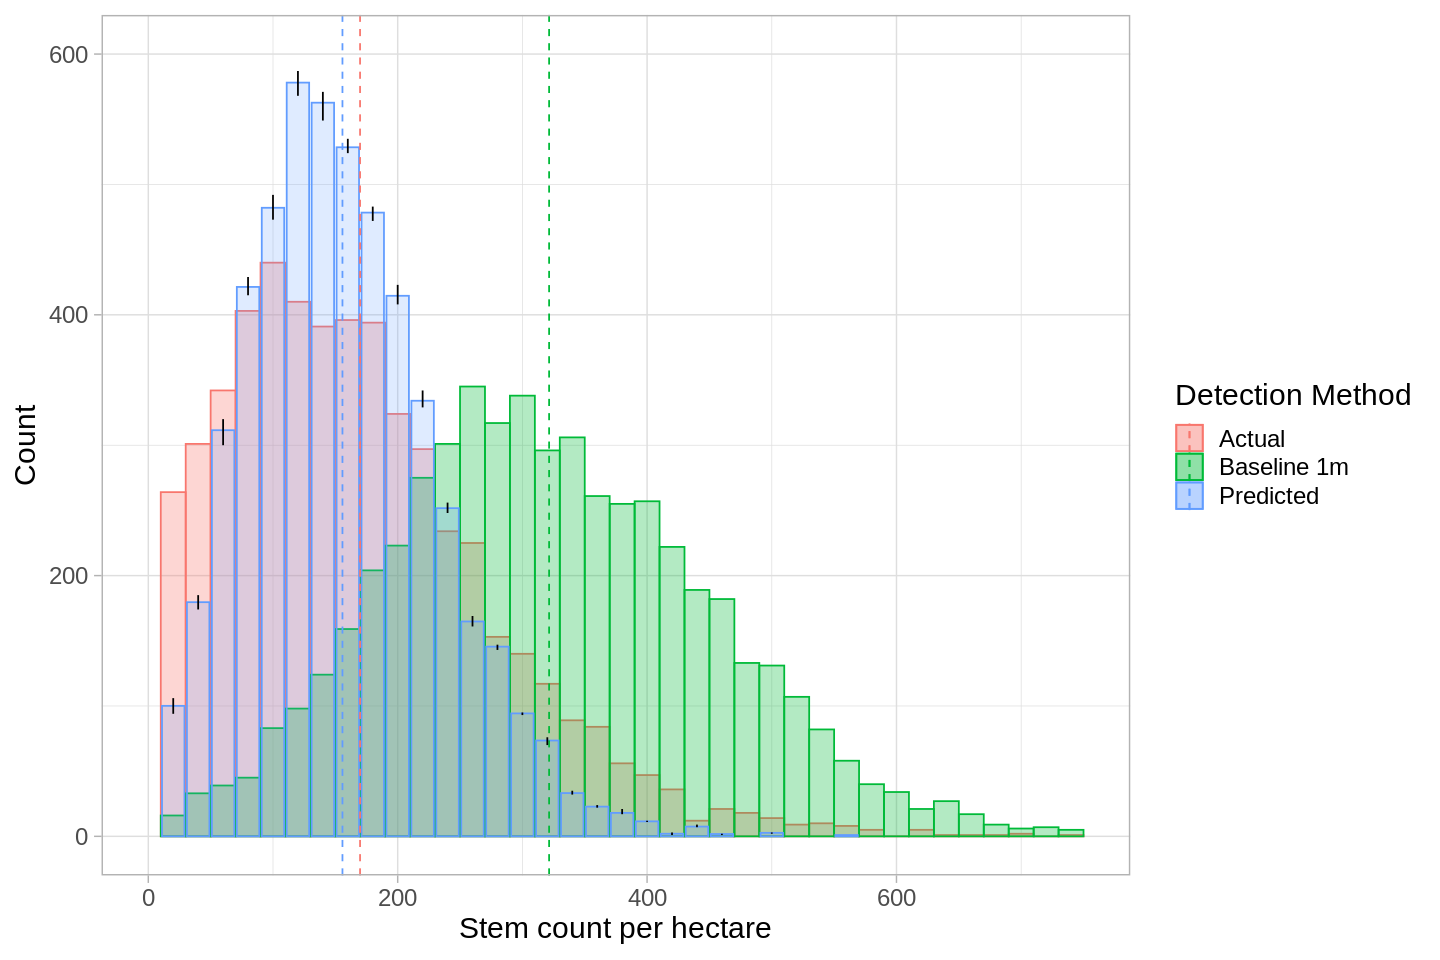

In [187]:
df <- rbind(df_actual,df_baseline)
mu <- ddply(df, "variable", summarise, grp.mean=mean(value))
mu_all <- ddply(df_predict_all, "variable", summarise, grp.mean=mean(value))

options(repr.plot.width=12, repr.plot.height=8)

font_base_size <- 18

ggplot(df, aes(x=value, fill=variable, color=variable)) +
  geom_histogram(alpha=0.3, binwidth =20, position="identity") +
  geom_bar(data=df_predict_binned,aes(x=bin, y=value, fill=variable, color=variable), alpha=0.2, stat="identity") +
  geom_vline(data=mu, aes(xintercept=grp.mean,color=variable), linetype="dashed")+
  geom_vline(data=mu_all, aes(xintercept=grp.mean, color=variable), linetype="dashed",show.legend=TRUE) +
  geom_linerange(data=df_predict_binned_summary, aes(x=bin, ymin=min, ymax=max), colour="black")+
  xlim(0,750) +
  ylim(0,600) +
  theme_light(base_size = font_base_size) +
  xlab("Stem count per hectare") +
  ylab("Count") +
  labs(fill="Detection Method",col="Detection Method")

ggsave(filename = "histogram_lm.png", width = 14, height = 8, device='png', dpi=300)


Warning message:
“Removed 140 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 140 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 396 rows containing missing values (geom_raster).”
Warning message:
“Removed 140 rows containing missing values (geom_point).”
Warning message:
“Removed 25 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 25 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 396 rows containing missing values (geom_raster).”
Warning message:
“Removed 25 rows containing missing values (geom_point).”


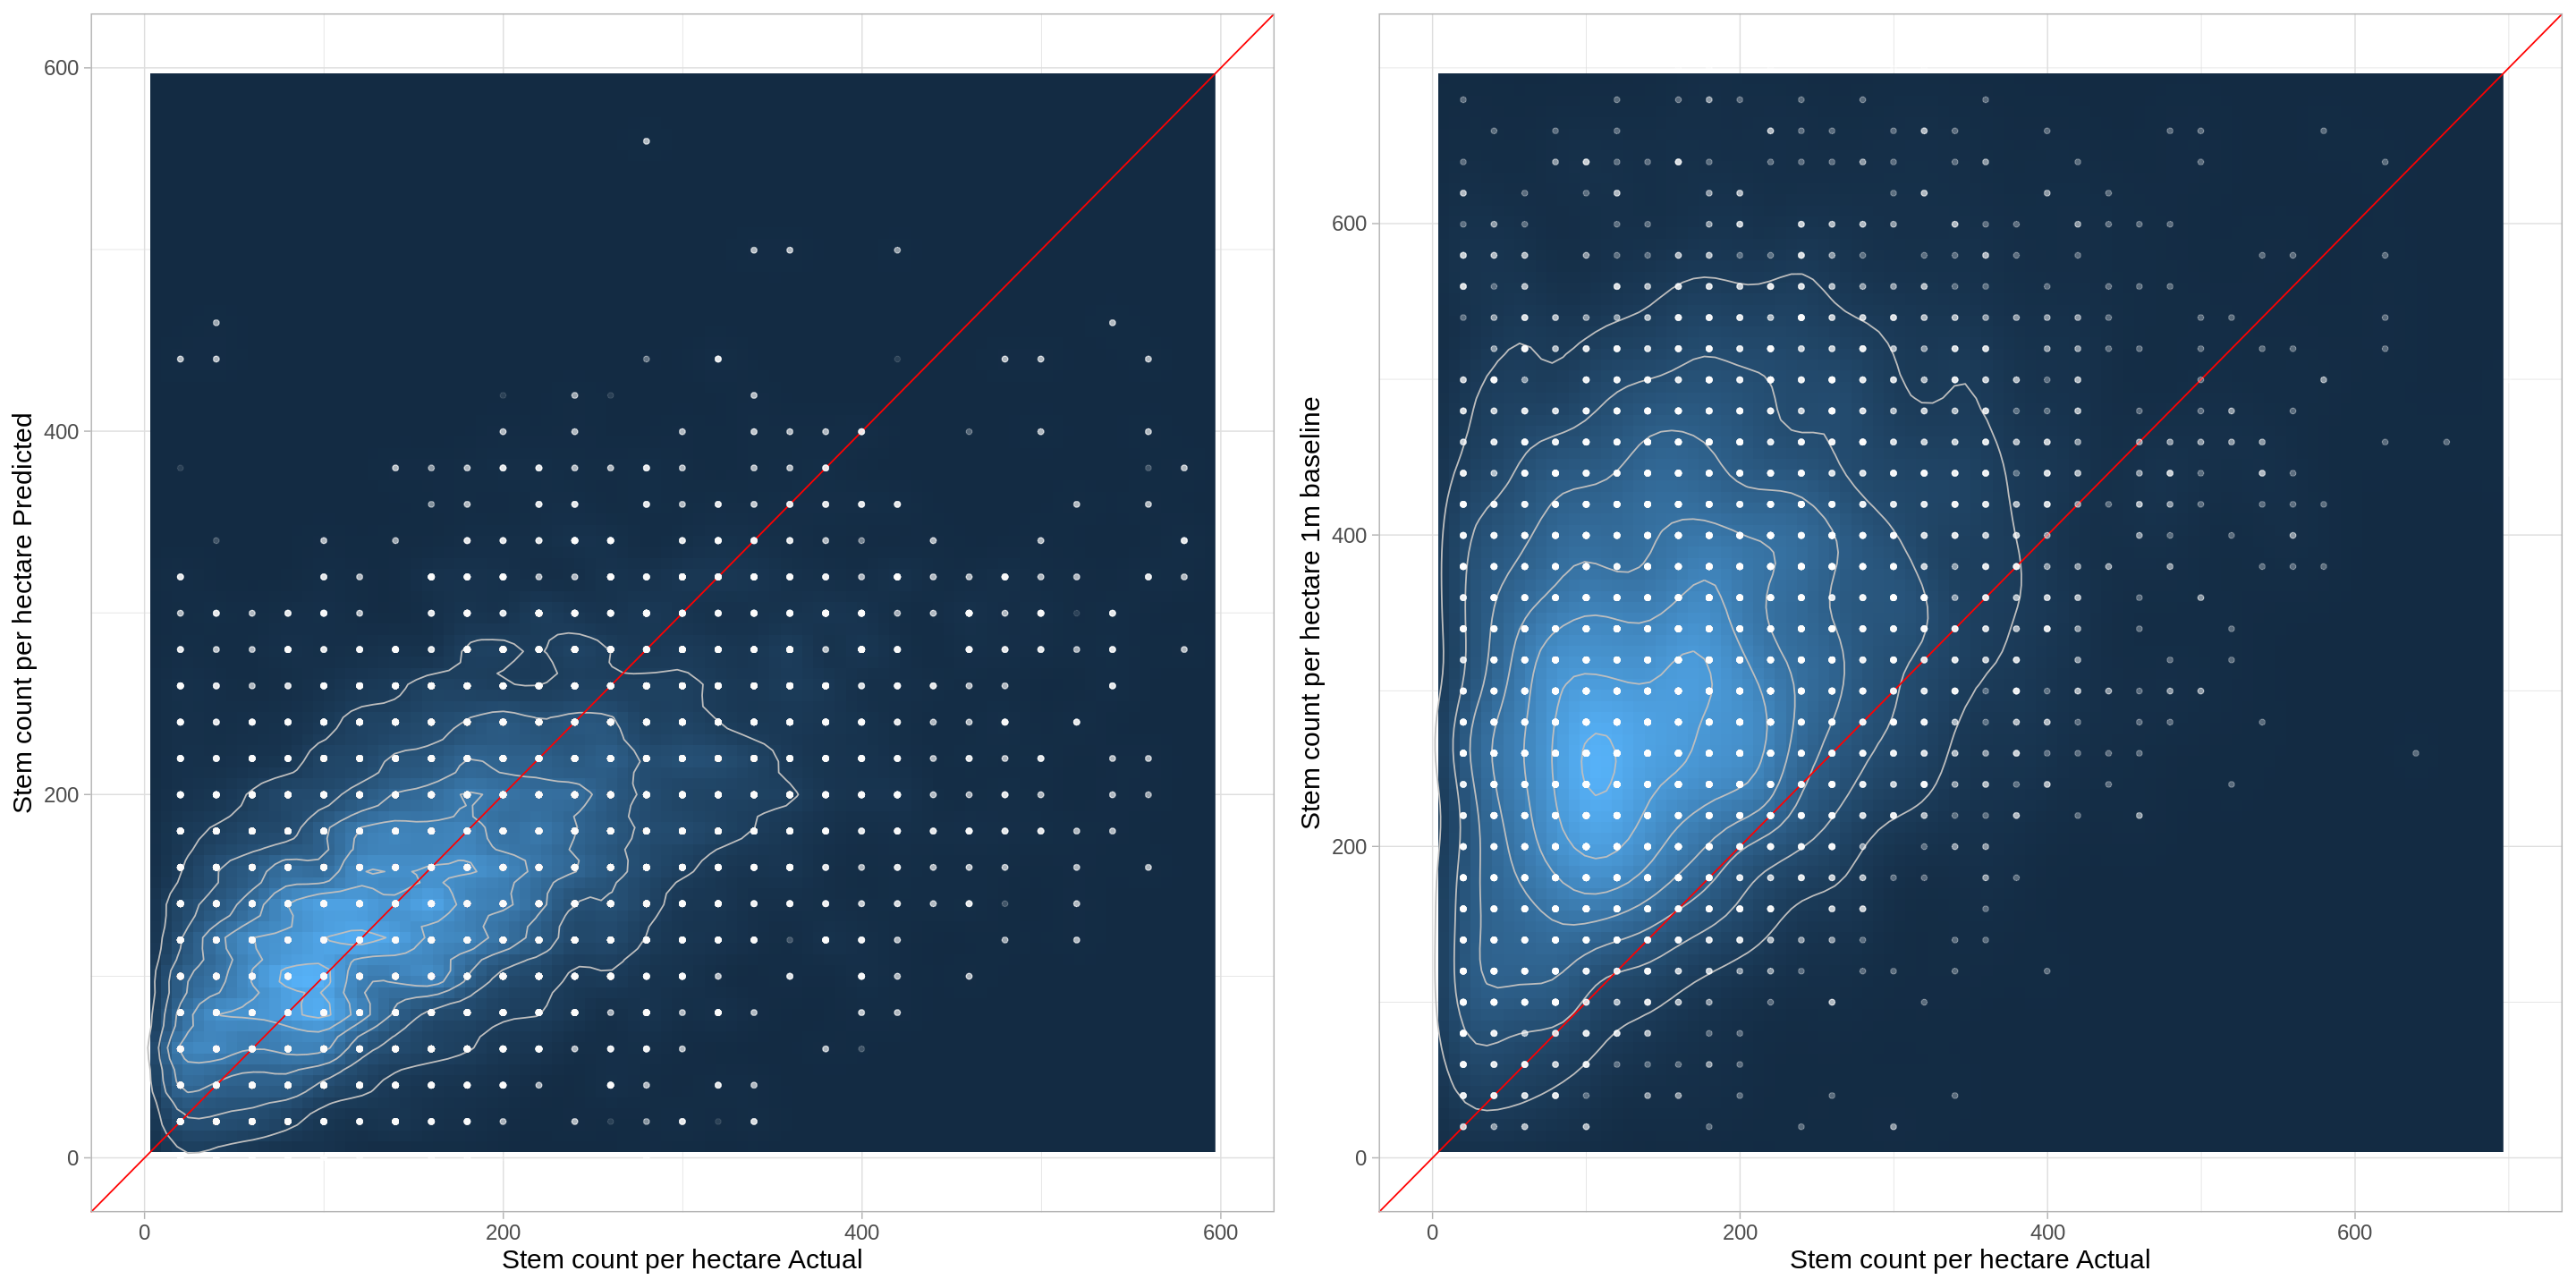

In [188]:
df <- data.frame(Actual=df_actual$value, Prediction=df_predict$value, Error=df_err$value)

df <- data.frame(Actual=df_actual$value, Prediction=df_predict_all$value)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 18

sc1 <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 

df <- data.frame(Actual=df_actual$value, Baseline=df_baseline$value, Error=df_err$value)


sc2 <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1, sc2, 
          #labels = c("Actual vs Predicted", "Actual vs Baseline"),
          ncol = 2, nrow = 1)
ggsave(filename = "scatter_actual_predicted_baseline.png", width = 24, height = 12, device='png', dpi=300)
